# Classification modeling
---

# TODO:
- interpret AUC curves
- can you add CUTI index to the plots of misclassified data? curious about whether misclassifications are concentrated around CUTI values near 0.
- question whether this notebook is too long.... I could put the log reg models and decision tree models into their own notebooks but it might make model comparison more annoying

---

For my baseline model, I need to ask myself what I'm actually trying to do and whether my audience cares more about accuracy or interpretation. In academic settings and Earth sciences, I prefer to prioritize interpretation since I'm working with real-world concepts and I'd like to be able to use these methods to learn about the oceanographic processes at play here. For this reason, I'll be using scikit-learn's Logistic Regression model, a straightforward classification model that prioritizes interpretability over accuracy. There are several assumptions we make about our data when we use this model, including assuming that our independent variables are independent *of each other*. 

However, I know this isn't the case in my data and the variables are strongly correlated with each other. Out of curiosity, I'm going to make a model with each feature individually as one way to avoid the multicollinearity, and then use polynomial features to engineer some interaction features and utilize regularization techniques to reduce the effect of multicollinearity. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

random.seed(42)

---
### Load the data

In [2]:
df = pd.read_csv('../../coastal_upwelling_output/clean_dataframe.csv')

In [3]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling,upwelling_multi
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731,1,1
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731,1,1
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731,1,1
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731,1,1
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731,1,1
...,...,...,...,...,...,...,...,...
329194,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194,0,0
329195,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194,0,0
329196,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194,0,0
329197,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194,0,0


This dataframe is over 300,000 observations, which I'm hesitant to pass to a model right away. I'm going to resample down to a small size at first, and then add data back in once the workflow is established.

In [4]:
df['time'] = pd.to_datetime(df['time'])

In [5]:
df_resampled = df.resample('20T', on='time').mean().dropna(how='all').reset_index().drop(columns=['CUTI', 'density'])
print(df_resampled.shape)

(17714, 6)


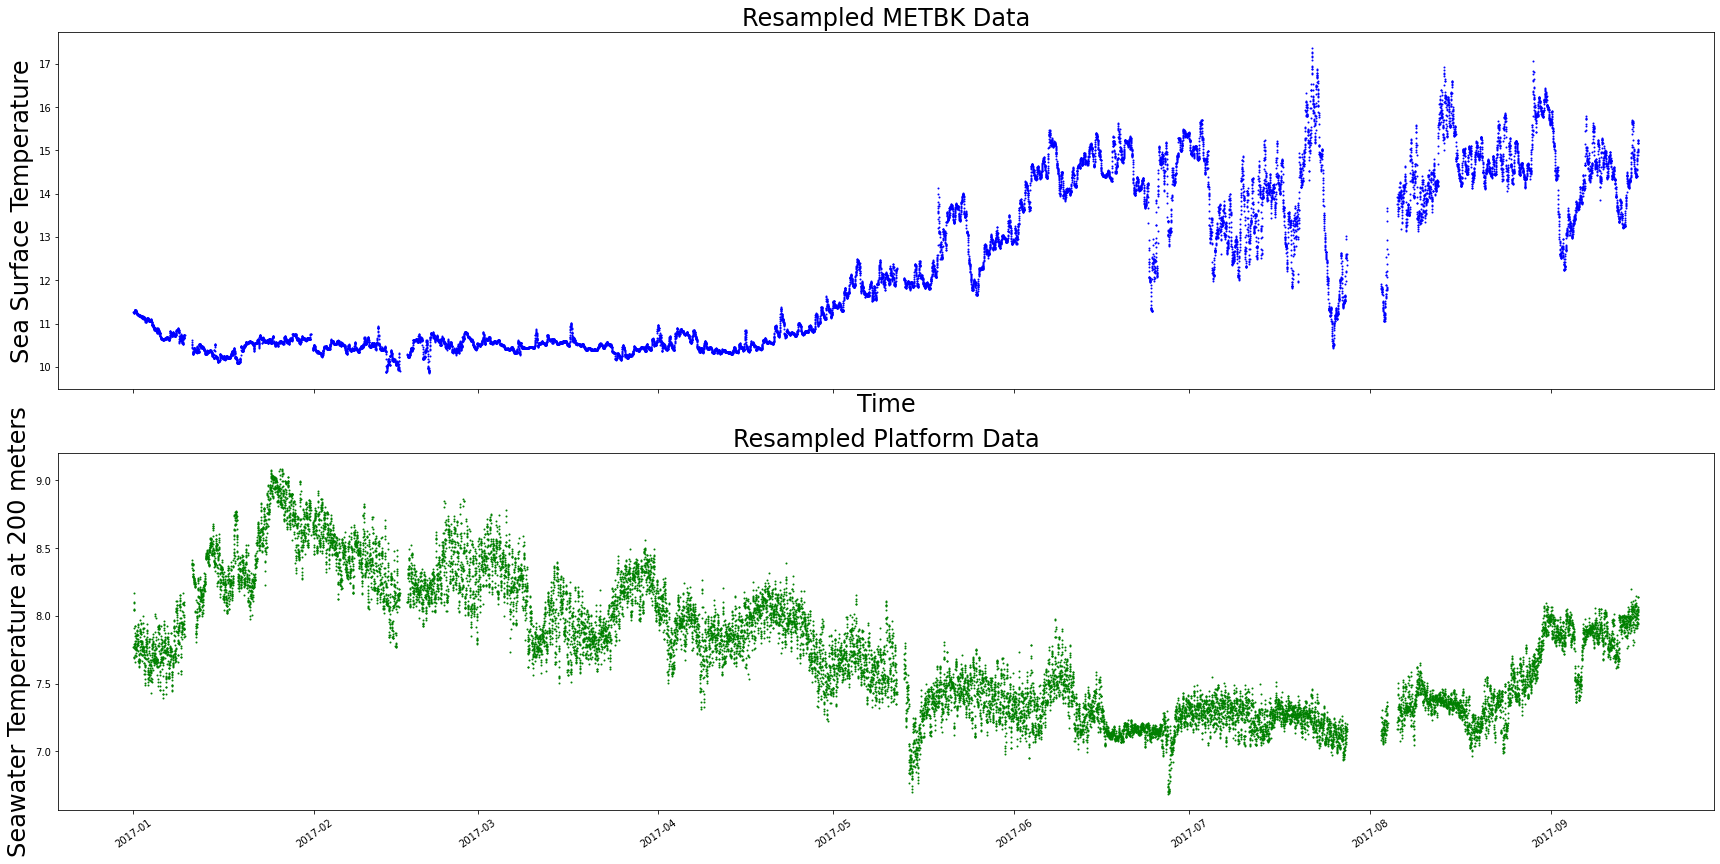

In [6]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Resampled Platform Data', size=24)

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

plt.xticks(rotation=35);
plt.tight_layout()

In [7]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0,1.0
...,...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0,0.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0,0.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0,0.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0,0.0


---
### Checking feature correlation

One of the big assumptions we make when building logistic regression models is that our independent features are independent of each other. We can print out a heatmap to check whether our features are correlated to each other or not.

In [16]:
df_resampled.drop(columns='upwelling_multi', inplace=True)

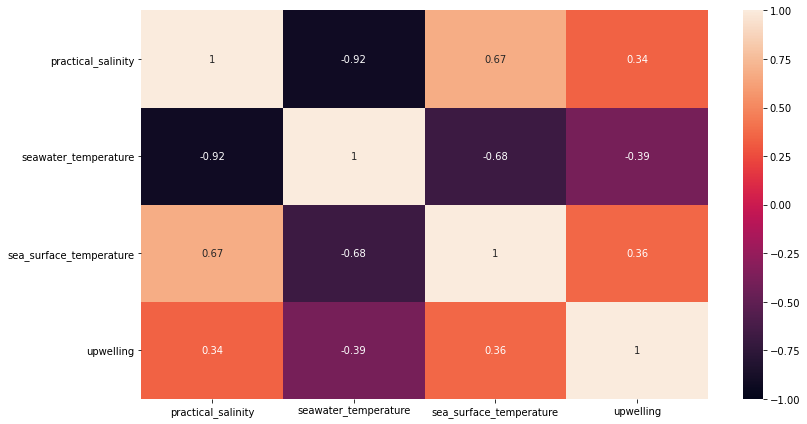

In [22]:
plt.figure(figsize=(12,6))

# corr = df_resampled.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))

svm = sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1) #, mask=mask);

plt.xticks(rotation=0) 

figure = svm.get_figure()    
plt.tight_layout()
figure.savefig('../figures/svm_conf.png', dpi=400)

Yup, looks like our features are correlated with each other! We can also tell from this heatmap that seawater temperature collected by the 200 meter platform is most strongly correlated to upwelling of all our features. I'll build a logistic regression model without addressing the multicollinearity first, and then attempt to improve it by using PolynomialFeatures and ridge and lasso penalties. 

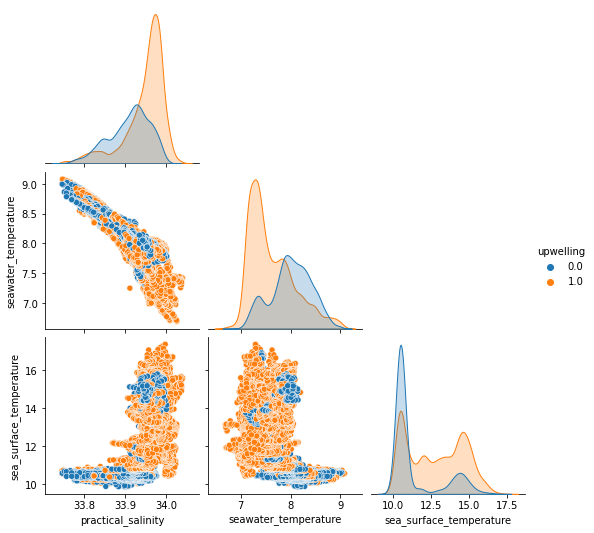

In [24]:
sns.pairplot(df_resampled, corner=True, hue='upwelling');
plt.savefig('../figures/pairplot.png')

In [30]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling,upwelling_multi
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0,1.0
...,...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0,0.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0,0.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0,0.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0,0.0


---
## Logistic regression classifiers

### Using only one feature

This sections is on building a model with only seawater temperature from the 200 meter platform as the prediction.

In [116]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0
...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0


In [134]:
X = df_resampled.drop(columns = ['upwelling', 'time'])
y = df_resampled['upwelling']

y.value_counts(normalize=True)

1.0    0.61951
0.0    0.38049
Name: upwelling, dtype: float64

If we created a null model that labeled all predictions as the majority class, we'd be correct about 61.96% of the time! This is the accuracy I'm hoping to beat with logistic regression or decision tree models.

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Create a pipeline with StandardScaler and LogisticRegression

In [141]:
pipe1 = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_params = {
    'logreg__penalty':['l1', 'l2'],
    'logreg__C': np.linspace(0.01, 10, 20)
}

pipe = GridSearchCV(pipe1, pipe_params, cv=5, verbose=2, return_train_score=True)

pipe.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END ...logreg__C=0.5357894736842106, logreg__penalty=l1; total time=   0.0s
[CV] END ...logreg__C=0.5357894736842106, logre

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'logreg__C': array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105263,
        7.89684211,  8.42263158,  8.94842105,  9.47421053, 10.        ]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=2)

In [142]:
print(f'Train accuracy: {pipe.score(X_train, y_train)}')
print(f'Test accuracy: {pipe.score(X_test, y_test)}')

Train accuracy: 0.7277380504328189
Test accuracy: 0.7258974937909235


In [138]:
# print(cross_val_score(pipe, X_train, y_train).mean())
# print(cross_val_score(pipe, X_test, y_test).mean())

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END ...logreg__C=0.5357894736842106, logreg__penalty=l1; total time=   0.0s
[CV] END ...logreg__C=0.5357894736842106, logre

KeyboardInterrupt: 

In [143]:
pipe.best_estimator_['logreg'].coef_

print(f'LogReg Coef: {np.exp(logreg.coef_)}')
sorted(list(zip(X.columns, coefs)), key=lambda x: x[1])

LogReg Coef: [[0.60148759 0.3521062  1.63888156]]


[('seawater_temperature', 0.0004515344205064465),
 ('sea_surface_temperature', 0.795308167660748),
 ('practical_salinity', 1.0)]

In [144]:
logreg = pipe.named_steps['logreg']
print(f'LogReg Intercept: {logreg.intercept_}')
print(f'LogReg Coef: {np.exp(logreg.coef_)}')
X_train.columns

AttributeError: 'GridSearchCV' object has no attribute 'named_steps'

This model performs better than our baseline, woohoo! But maybe we can do better with polynomial features.

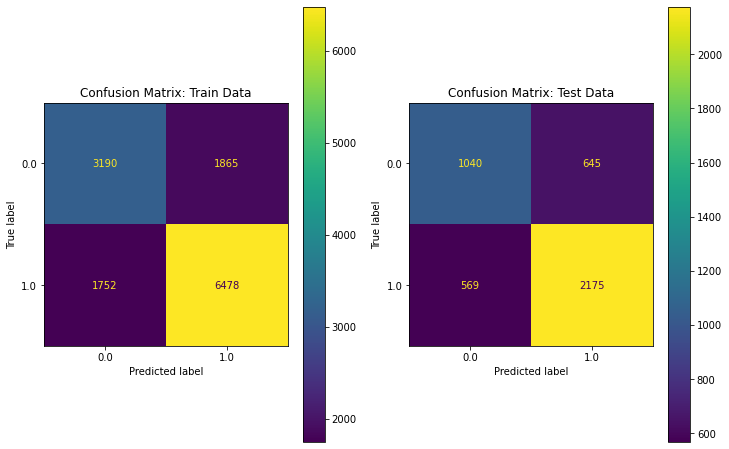

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_confusion_matrix(pipe, X_train, y_train, ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

plot_confusion_matrix(pipe, X_test, y_test, ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [149]:
test_preds = pipe.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.62      0.63      1685
         1.0       0.77      0.79      0.78      2744

    accuracy                           0.73      4429
   macro avg       0.71      0.70      0.71      4429
weighted avg       0.72      0.73      0.72      4429



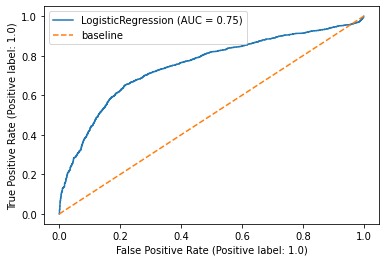

In [19]:
# ROC curve
plot_roc_curve(logreg, X_test.values.reshape(-1, 1), y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

---
### Using PolynomialFeatures

Now let's add those features back in and use feature interactions combined with regularization to try upping the accuracy while accounting for the multicollinearity.

An easy way to get a variety of feature interactions is using sklearn's PolynomialFeatures function. There are four features in this model, so I'll set the degree to 4 so that there will be an engineered feature that includes all 4 of the original features. 

In [181]:
X = df_resampled.drop(columns=['upwelling', 'time'])
y = df_resampled['upwelling']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [182]:
y.value_counts(normalize=True)

1.0    0.61951
0.0    0.38049
Name: upwelling, dtype: float64

In [185]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_params = {
    'logreg__penalty':['l1', 'l2'],
    'logreg__C': np.linspace(0.01, 1, 10)
}

gs_lr = GridSearchCV(pipe, pipe_params, cv=5, verbose=2, return_train_score=True)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.12, logreg__penalty=l1; total time=   0.9s
[CV] END .................logreg__C=0.12, logre

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('sc', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'logreg__C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=2)

In [186]:
print(f'Best parameters: {gs_lr.best_params_}')
print(f'Best score: {gs_lr.best_score_}')

Best parameters: {'logreg__C': 1.0, 'logreg__penalty': 'l1'}
Best score: 0.7457282649604818


Now that we have the best parameters, we can create a logistic regression model with these parameters and see what the coefficients are for our poly features.

In [187]:
print(gs_lr.cv_results_['mean_train_score'].mean())
print(gs_lr.cv_results_['mean_test_score'].mean())

0.7400526910048927
0.7397327813323298


In [188]:
print(f'Train accuracy: {gs_lr.score(X_train, y_train)}')
print(f'Test accuracy: {gs_lr.score(X_test, y_test)}')

Train accuracy: 0.7461046292811442
Test accuracy: 0.753217430571235


Question to self: do the coefficients need to be exponentiated to get their actual values, since the logistic regression model uses the logit function to transform the data?

In [189]:
gs_lr.predict(X_train)

array([1., 0., 1., ..., 0., 0., 1.])

In [180]:
gs_lr.best_estimator_['logreg'].coef_

print(f'LogReg Coef: {np.exp(logreg.coef_)}')

LogReg Coef: [[0.60148759 0.3521062  1.63888156]]


In [159]:
poly_features = gs_lr.estimator.named_steps['poly'].fit(X_train).get_feature_names(X.columns)
coefs = np.exp(gs_lr.best_estimator_['logreg'].coef_[0])
gs_lr.best_estimator_['logreg'].coef_[0]

array([-0.4493528 , -7.35961021, -0.44308407,  0.61247678, -9.14691201,
        0.10832814, 14.2212885 ,  3.6565144 , -3.96000191])

In [160]:
coefs

array([6.38040961e-01, 6.36446495e-04, 6.42053228e-01, 1.84499539e+00,
       1.06548316e-04, 1.11441337e+00, 1.50046933e+06, 3.87261235e+01,
       1.90630779e-02])

In [161]:
gs_lr.best_estimator_['logreg'].coef_

print(f'LogReg Coef: {np.exp(logreg.coef_)}')
sorted(list(zip(poly_features, coefs)), key=lambda x: x[1])

LogReg Coef: [[0.60148759 0.3521062  1.63888156]]


[('practical_salinity seawater_temperature', 0.00010654831577390462),
 ('seawater_temperature', 0.0006364464945086985),
 ('sea_surface_temperature^2', 0.019063077861707488),
 ('practical_salinity', 0.6380409608543002),
 ('sea_surface_temperature', 0.6420532283655118),
 ('practical_salinity sea_surface_temperature', 1.1144133716021192),
 ('practical_salinity^2', 1.8449953927484306),
 ('seawater_temperature sea_surface_temperature', 38.72612347332337),
 ('seawater_temperature^2', 1500469.3284879457)]

In [162]:
gs_lr_train_preds = gs_lr.predict(X_train)
gs_lr_test_preds = gs_lr.predict(X_test)

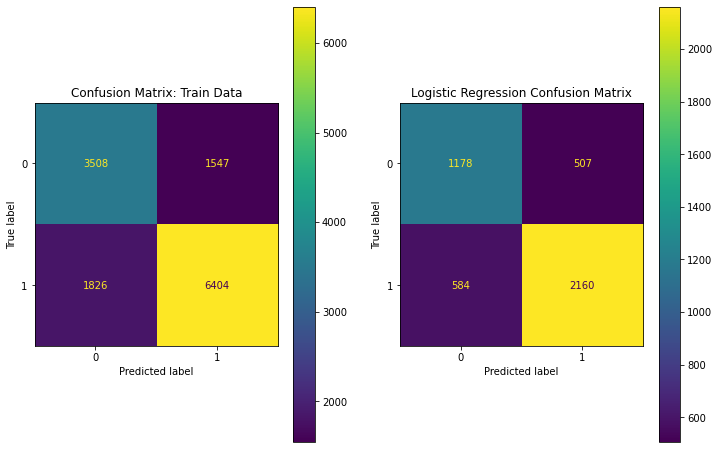

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_lr_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_lr_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

plt.title('Logistic Regression Confusion Matrix')
plt.savefig('../figures/log_reg_confusion_matrix.png')

Looks like our false negatives outnumber our false positives

In [164]:
print(classification_report(y_test, gs_lr_test_preds))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68      1685
         1.0       0.81      0.79      0.80      2744

    accuracy                           0.75      4429
   macro avg       0.74      0.74      0.74      4429
weighted avg       0.76      0.75      0.75      4429



In [165]:
class_report_1 = pd.DataFrame(classification_report(y_test, gs_lr_test_preds, output_dict=True)).transpose()
class_report_1.rename(index={'0.0':'Not Upwelling', '1.0':'Upwelling'}, inplace=True)
class_report_1.drop(index=['macro avg', 'weighted avg', 'accuracy'], columns=['support'], inplace=True)
# https://stackoverflow.com/questions/40427943/how-do-i-change-a-single-index-value-in-pandas-dataframe
class_report_1

,precision,recall,f1-score
Not Upwelling,0.668558,0.699110,0.683493
Upwelling,0.809899,0.787172,0.798374


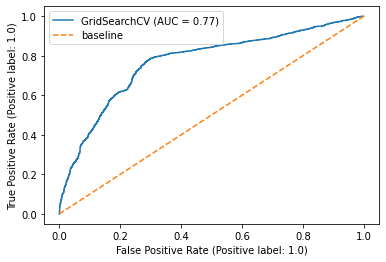

In [166]:
# ROC curve
plot_roc_curve(gs_lr, X_test, y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

#### Explore misclassified data

In [34]:
# Get indices of misclassified data source: https://stackoverflow.com/questions/25551977/retrieve-misclassified-documents-using-scikitlearn
misclass_ind_lr = np.where(y_test != gs_lr_test_preds)
misclass_ind_lr

(array([   2,    8,   11, ..., 4425, 4426, 4427], dtype=int64),)

In [35]:
X_test_times = df_resampled.iloc[X_test.index]['time']

In [36]:
X_test_times.iloc[misclass_ind_lr]

7832    2017-04-22 22:00:00
238     2017-01-04 07:20:00
1022    2017-01-16 11:00:00
546     2017-01-08 14:00:00
17165   2017-09-08 09:00:00
                ...        
9663    2017-05-19 14:20:00
4956    2017-03-13 23:20:00
314     2017-01-05 08:40:00
307     2017-01-05 06:20:00
7074    2017-04-12 09:20:00
Name: time, Length: 1092, dtype: datetime64[ns]

In [37]:
pd.DataFrame(X_test_times.iloc[misclass_ind_lr]).reset_index(drop=True)

,time
0,2017-04-22 22:00:00
1,2017-01-04 07:20:00
2,2017-01-16 11:00:00
3,2017-01-08 14:00:00
4,2017-09-08 09:00:00
...,...
1087,2017-05-19 14:20:00
1088,2017-03-13 23:20:00
1089,2017-01-05 08:40:00
1090,2017-01-05 06:20:00


In [38]:
frames_lr = [pd.DataFrame(X_test_times.iloc[misclass_ind_lr]), X_test.iloc[misclass_ind_lr], pd.DataFrame(y_test.iloc[misclass_ind_lr])]
misclass_df_lr = pd.concat(frames_lr, axis=1)

In [39]:
misclass_df_lr

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling
7832,2017-04-22 22:00:00,33.872223,8.268149,10.734294,1.0
238,2017-01-04 07:20:00,33.904936,7.847660,10.968450,1.0
1022,2017-01-16 11:00:00,33.895588,8.239252,10.237200,1.0
546,2017-01-08 14:00:00,33.924423,7.714611,10.868400,0.0
17165,2017-09-08 09:00:00,33.987337,7.844016,15.461583,0.0
...,...,...,...,...,...
9663,2017-05-19 14:20:00,33.976587,7.240744,12.525300,0.0
4956,2017-03-13 23:20:00,33.918348,8.098221,10.649550,1.0
314,2017-01-05 08:40:00,33.895039,7.927354,10.842200,1.0
307,2017-01-05 06:20:00,33.897029,7.920439,10.870000,1.0


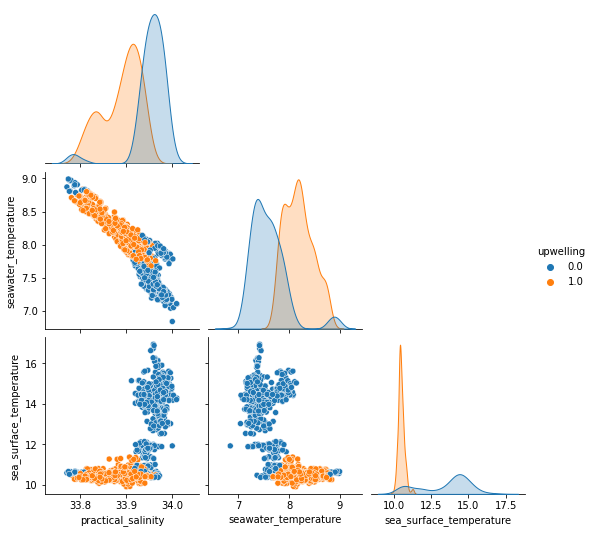

In [40]:
sns.pairplot(misclass_df_lr, corner=True, hue='upwelling');

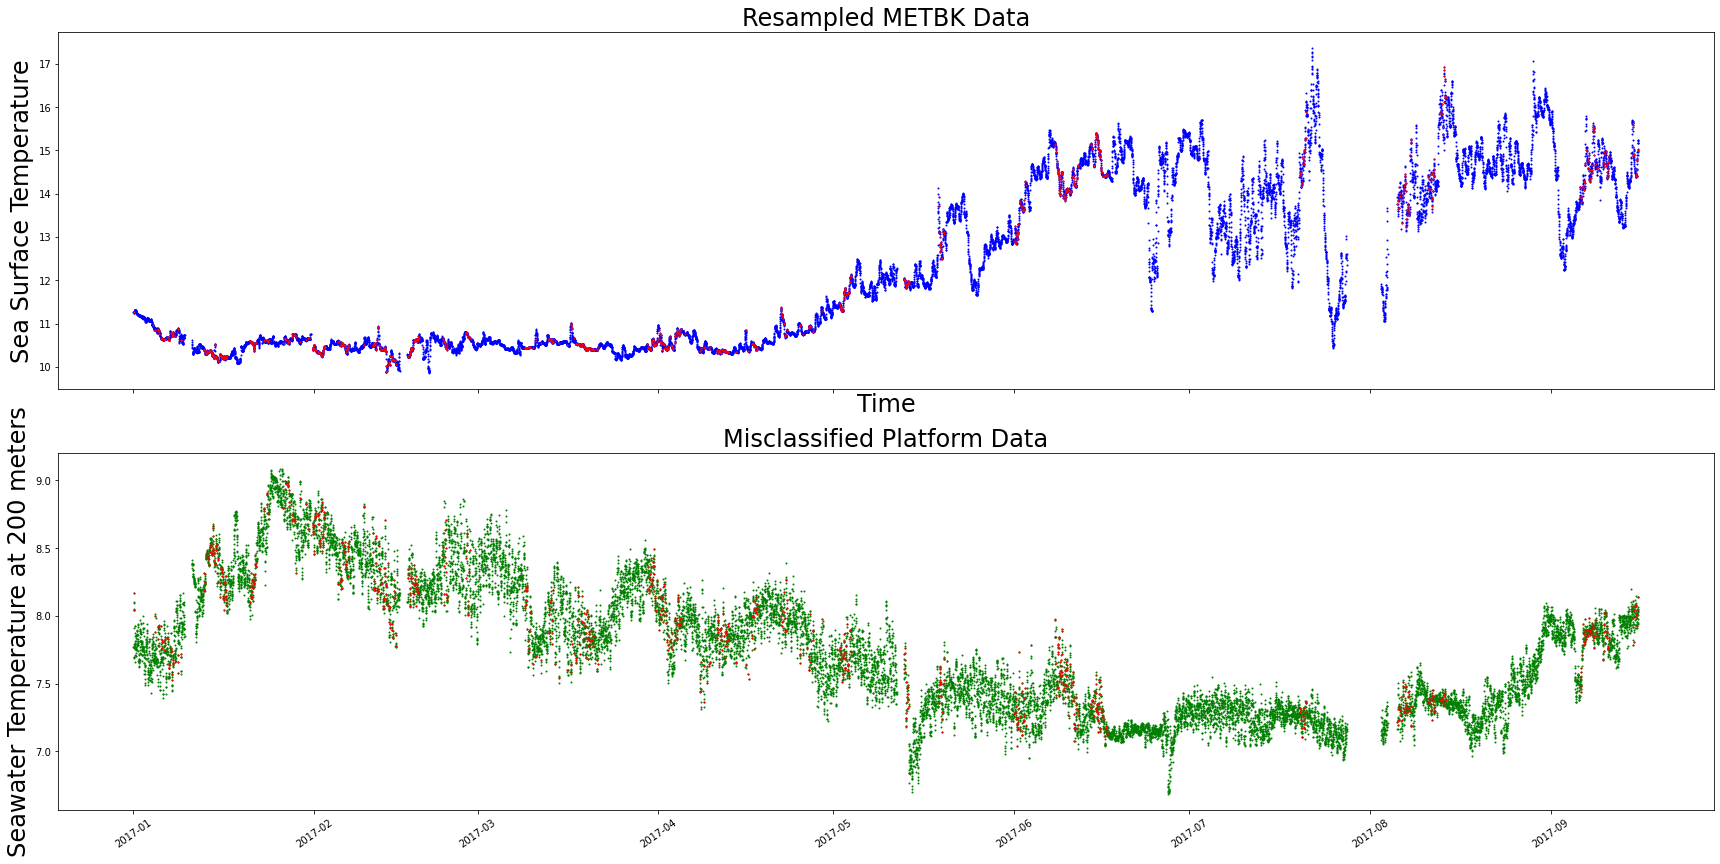

In [40]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Misclassified Platform Data', size=24)

ax1.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['seawater_temperature'], c='r', s=1)

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

ax2.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['sea_surface_temperature'], c='r', s=1)



plt.xticks(rotation=35);
plt.tight_layout()

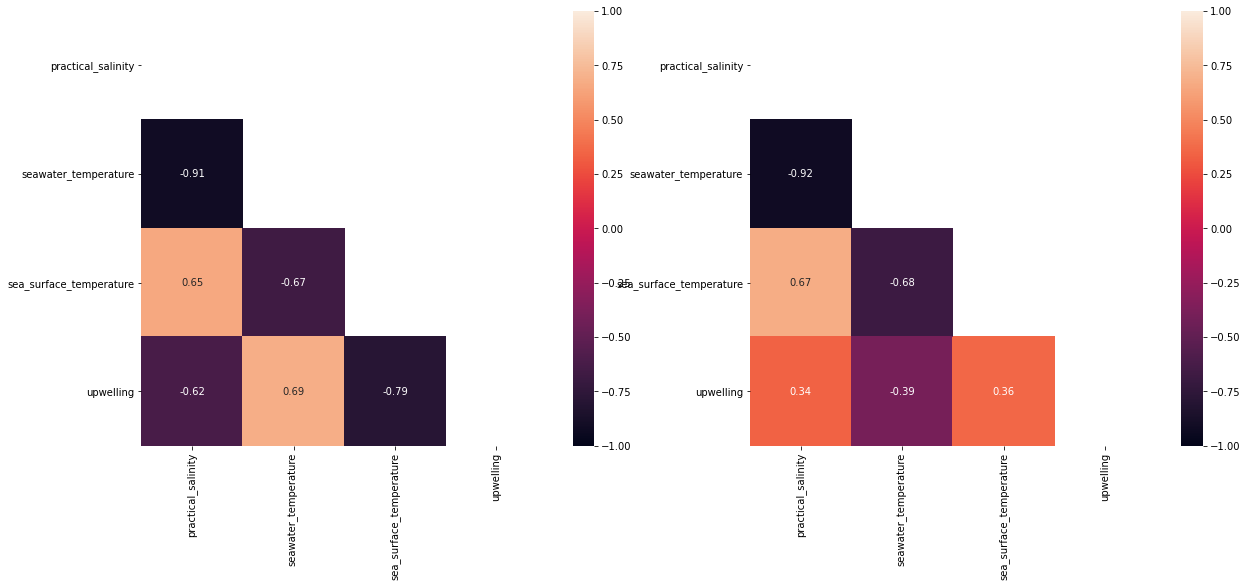

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

corr = misclass_df_lr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(misclass_df_lr.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax1)

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax2);

---
### Decision tree classifiers
Decision trees come in a lot of different shapes, so it'd be best to use GridSearchCV to find the best parameters for a tree for upwelling classification.

In [93]:
df_resampled

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling
0,2017-01-01 00:00:00,33.917802,7.768099,11.27030,1.0
1,2017-01-01 00:20:00,33.923736,7.695256,11.26795,1.0
2,2017-01-01 00:40:00,33.925383,7.688413,11.26675,1.0
3,2017-01-01 01:00:00,33.926747,7.698557,11.26465,1.0
4,2017-01-01 01:20:00,33.916462,7.764130,11.26475,1.0
...,...,...,...,...,...
17709,2017-09-15 22:20:00,33.948736,8.005974,15.24465,0.0
17710,2017-09-15 22:40:00,33.946218,8.028650,15.25365,0.0
17711,2017-09-15 23:00:00,33.953680,7.949766,15.22895,0.0
17712,2017-09-15 23:20:00,33.942572,8.052701,15.17020,0.0


In [167]:
X = df_resampled.drop(columns=['time', 'upwelling'])
y = df_resampled['upwelling']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [169]:
df_resampledgrid = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0, 0.01, 0.1, 1, 10]
}

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                 param_grid=param_grid,
                 verbose=1,
                 cv=5)

%time gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 33.4 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'max_depth': [5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]},
             verbose=1)

In [170]:
gs_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=9, min_samples_leaf=6,
                       min_samples_split=20)

In [171]:
print(f'Score on training set: {gs_dt.score(X_train, y_train)}')
print(f'Score on testing set: {gs_dt.score(X_test, y_test)}')

Score on training set: 0.8184418517124576
Score on testing set: 0.7943102280424476


In [172]:
gs_dt_train_preds = gs_dt.predict(X_train)
gs_dt_test_preds = gs_dt.predict(X_test)

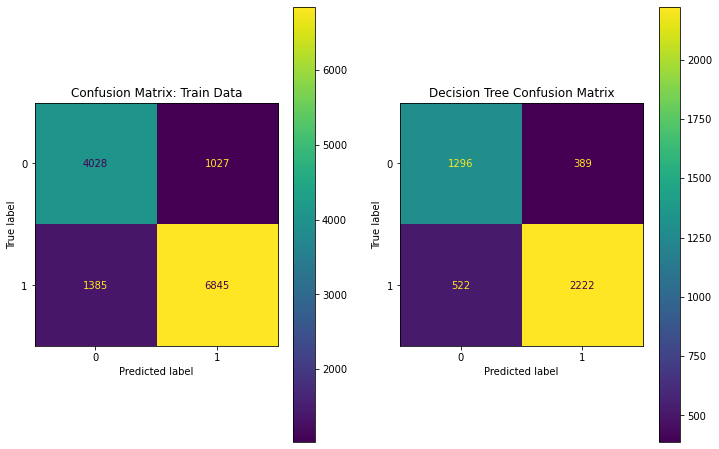

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_dt_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_dt_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');


plt.title('Decision Tree Confusion Matrix')
plt.savefig('../figures/dec_tree_confusion_matrix.png')

In [174]:
print(gs_dt.best_estimator_.feature_importances_)
list(X_train.columns)

[0.14116155 0.14112591 0.71771255]


['practical_salinity', 'seawater_temperature', 'sea_surface_temperature']

In [175]:
class_report_2 = pd.DataFrame(classification_report(y_test, gs_dt_test_preds, output_dict=True)).transpose()
class_report_2.rename(index={'0.0':'Not Upwelling', '1.0':'Upwelling'}, inplace=True)
class_report_2.drop(index=['macro avg', 'weighted avg', 'accuracy'], columns=['support'], inplace=True)
# https://stackoverflow.com/questions/40427943/how-do-i-change-a-single-index-value-in-pandas-dataframe
class_report_2

,precision,recall,f1-score
Not Upwelling,0.712871,0.769139,0.739937
Upwelling,0.851015,0.809767,0.829879


We saw that `seawater_temperature` was the most strongly correlated feature to upwelling, but `sea_surface_temperature` ended up having the greatest feature importance. I want to trust the model on this, but I'm wondering why this happened. 

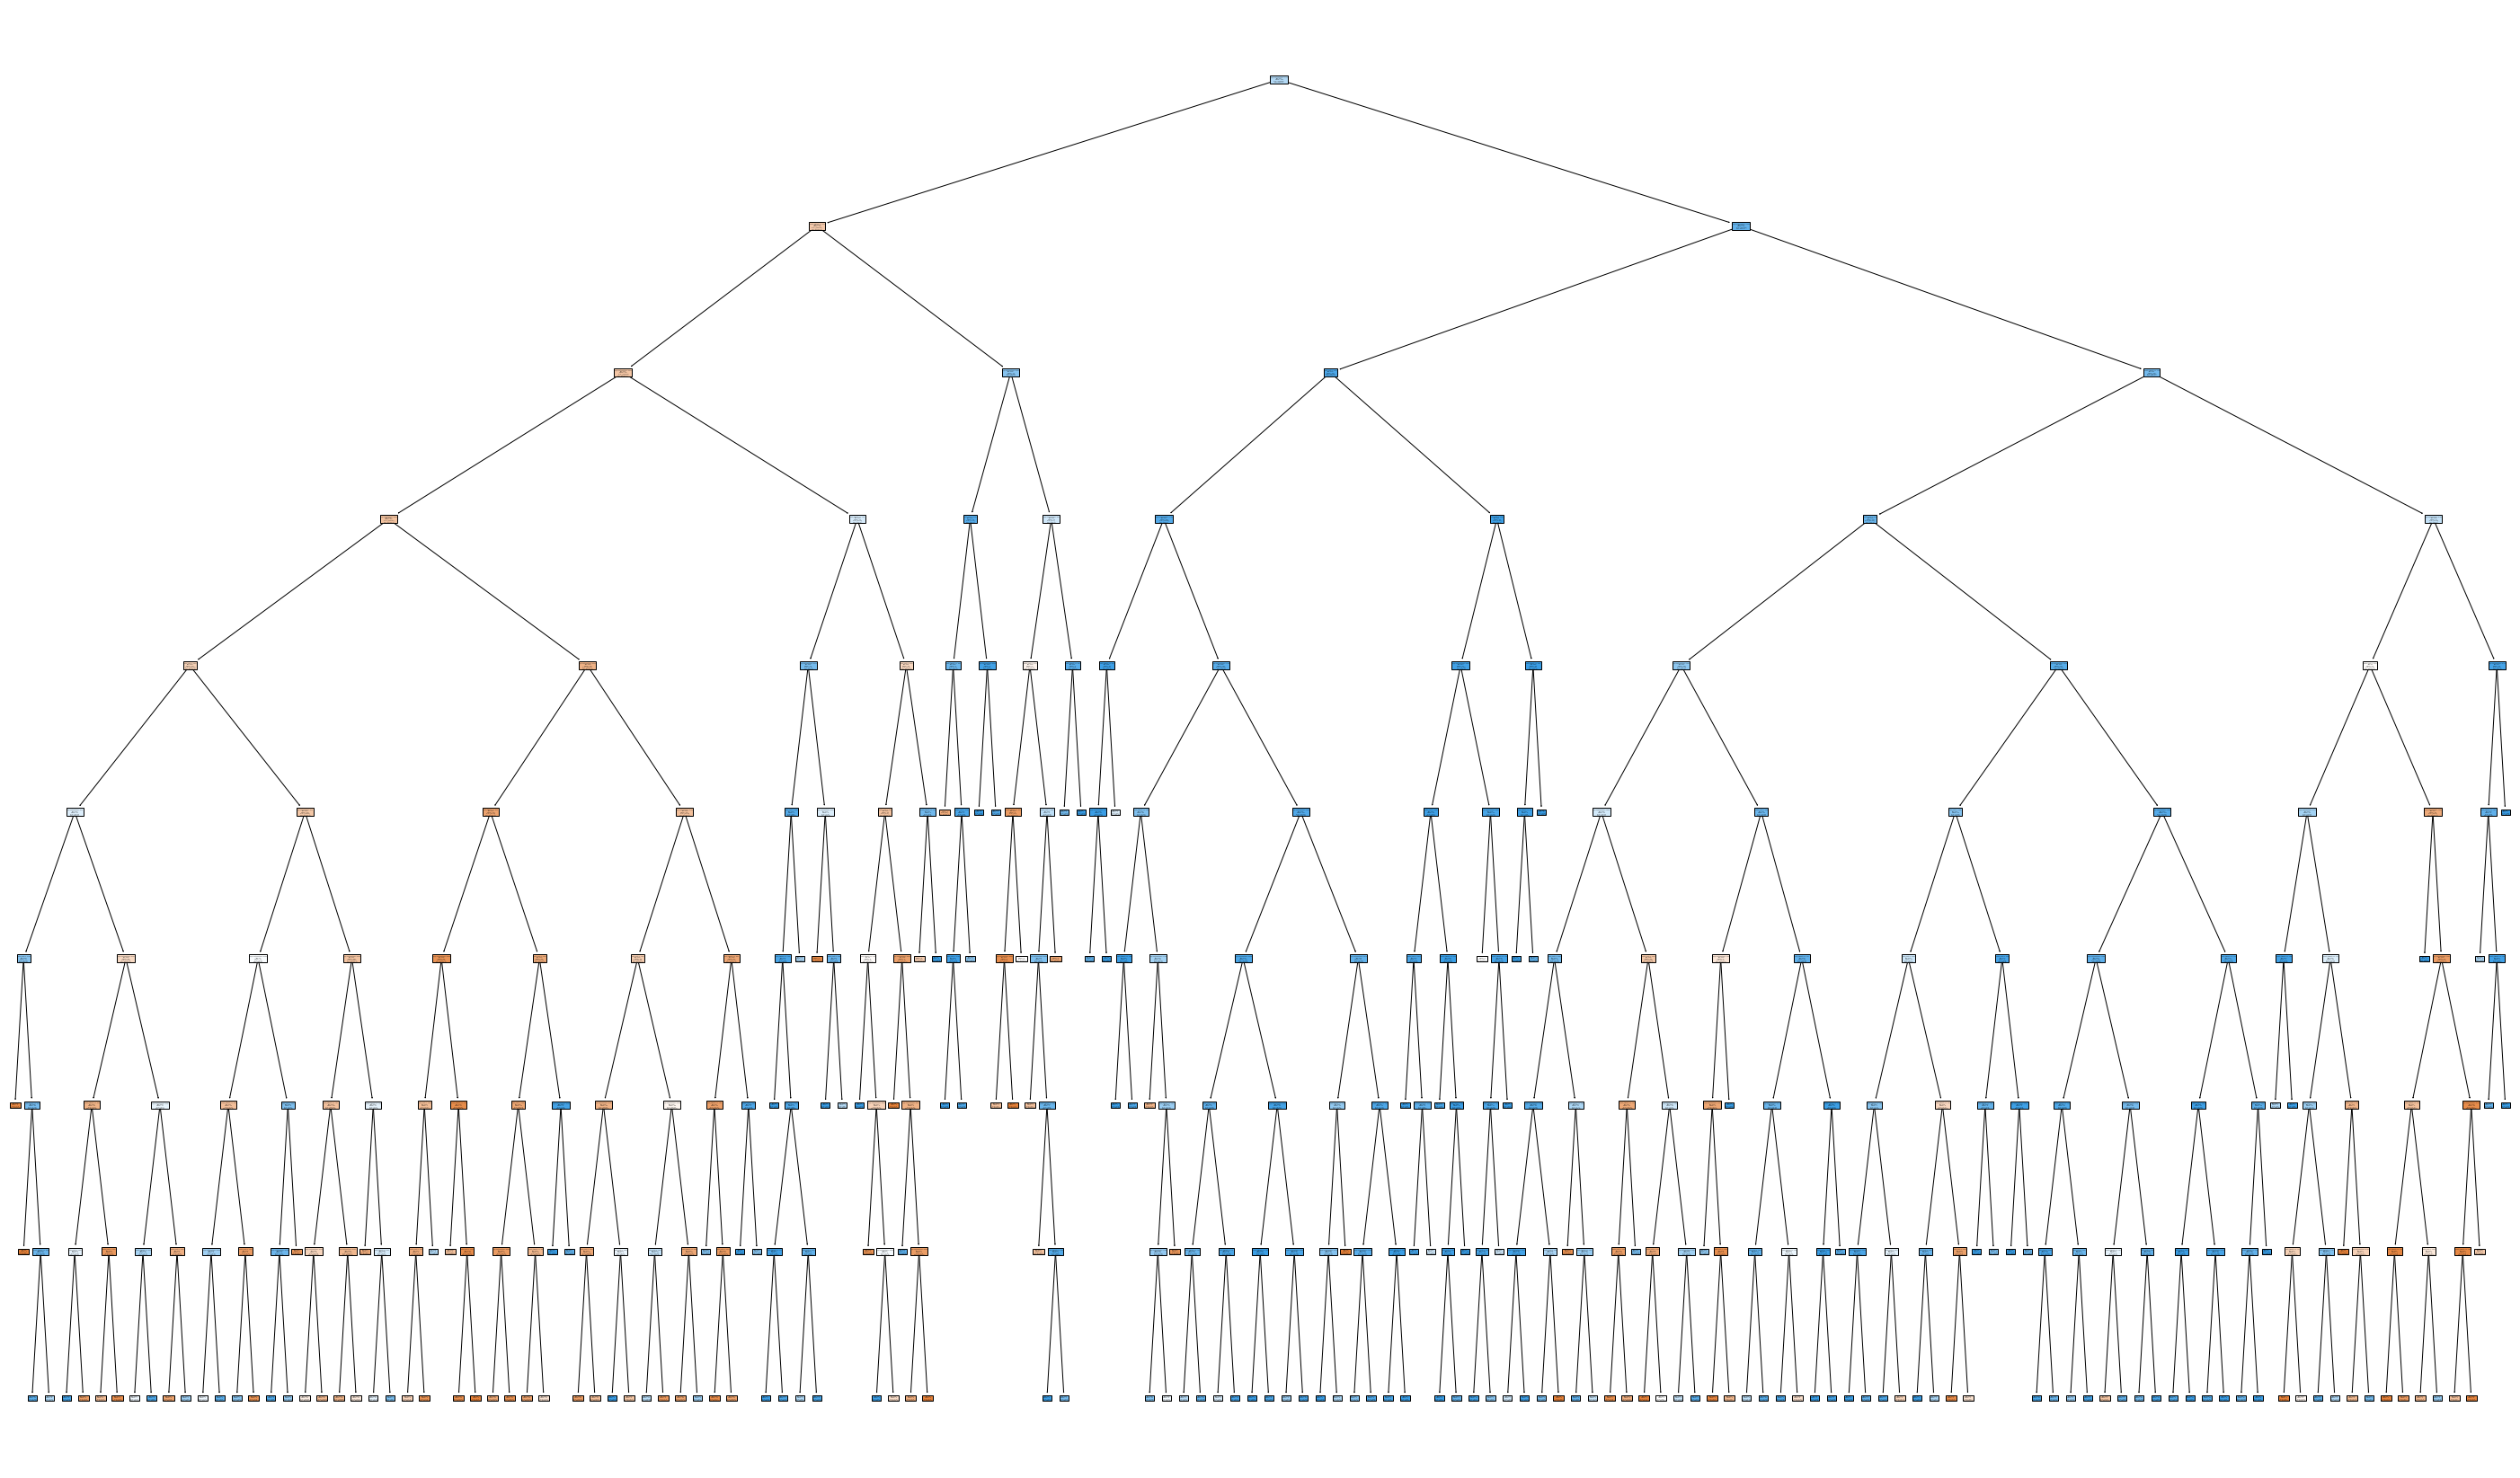

In [176]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(gs_dt.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Not upwelling', 'Upwelling'],
          filled = True);

In [177]:
print(export_text(gs_dt.best_estimator_,
                  list(X_train.columns)));

|--- sea_surface_temperature <= 11.01
|   |--- seawater_temperature <= 8.79
|   |   |--- sea_surface_temperature <= 10.83
|   |   |   |--- sea_surface_temperature <= 10.52
|   |   |   |   |--- practical_salinity <= 33.84
|   |   |   |   |   |--- sea_surface_temperature <= 10.38
|   |   |   |   |   |   |--- practical_salinity <= 33.79
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- practical_salinity >  33.79
|   |   |   |   |   |   |   |--- seawater_temperature <= 8.33
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- seawater_temperature >  8.33
|   |   |   |   |   |   |   |   |--- seawater_temperature <= 8.58
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- seawater_temperature >  8.58
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- sea_surface_temperature >  10.38
|   |   |   |   |   |   |--- sea_surface_temperature <= 10.44
|   |   |   |   |   |   |   |--- se

c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass feature_names=['practical_salinity', 'seawater_temperature', 'sea_surface_temperature'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [178]:
print(classification_report(y_test, gs_dt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      1685
         1.0       0.85      0.81      0.83      2744

    accuracy                           0.79      4429
   macro avg       0.78      0.79      0.78      4429
weighted avg       0.80      0.79      0.80      4429



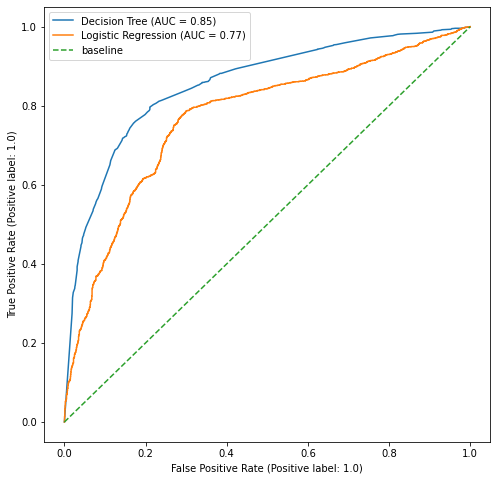

In [179]:
# ROC curve
fig, ax = plt.subplots(figsize=(8,8))

plot_roc_curve(gs_dt, X_test, y_test, ax=ax, name='Decision Tree')
plot_roc_curve(gs_lr, X_test, y_test, ax=ax, name='Logistic Regression')

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

Interpretation goes here

#### Explore misclassified data

In [54]:
# Get indices of misclassified data
misclass_ind_dt = np.where(y_test != gs_dt_test_preds)
# misclass_ind_dt

In [55]:
X_test_times = df_resampled.iloc[X_test.index]['time']

In [56]:
X_test_times.iloc[misclass_ind_dt]

7832    2017-04-22 22:00:00
1022    2017-01-16 11:00:00
546     2017-01-08 14:00:00
308     2017-01-05 06:40:00
5441    2017-03-20 17:00:00
                ...        
2519    2017-02-06 19:00:00
5282    2017-03-18 12:00:00
9663    2017-05-19 14:20:00
17408   2017-09-11 18:00:00
7074    2017-04-12 09:20:00
Name: time, Length: 912, dtype: datetime64[ns]

In [57]:
pd.DataFrame(X_test_times.iloc[misclass_ind_dt]).reset_index(drop=True)

,time
0,2017-04-22 22:00:00
1,2017-01-16 11:00:00
2,2017-01-08 14:00:00
3,2017-01-05 06:40:00
4,2017-03-20 17:00:00
...,...
907,2017-02-06 19:00:00
908,2017-03-18 12:00:00
909,2017-05-19 14:20:00
910,2017-09-11 18:00:00


In [58]:
frames_dt = [pd.DataFrame(X_test_times.iloc[misclass_ind_dt]), X_test.iloc[misclass_ind_dt], pd.DataFrame(y_test.iloc[misclass_ind_dt])]
misclass_df_dt = pd.concat(frames_dt, axis=1)

In [59]:
misclass_df_dt

,time,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling
7832,2017-04-22 22:00:00,33.872223,8.268149,10.734294,1.0
1022,2017-01-16 11:00:00,33.895588,8.239252,10.237200,1.0
546,2017-01-08 14:00:00,33.924423,7.714611,10.868400,0.0
308,2017-01-05 06:40:00,33.909872,7.833028,10.858200,1.0
5441,2017-03-20 17:00:00,33.947078,7.776514,10.384850,1.0
...,...,...,...,...,...
2519,2017-02-06 19:00:00,33.826399,8.517313,10.433500,1.0
5282,2017-03-18 12:00:00,33.944735,7.652431,10.513300,1.0
9663,2017-05-19 14:20:00,33.976587,7.240744,12.525300,0.0
17408,2017-09-11 18:00:00,33.938600,7.971239,14.612300,1.0


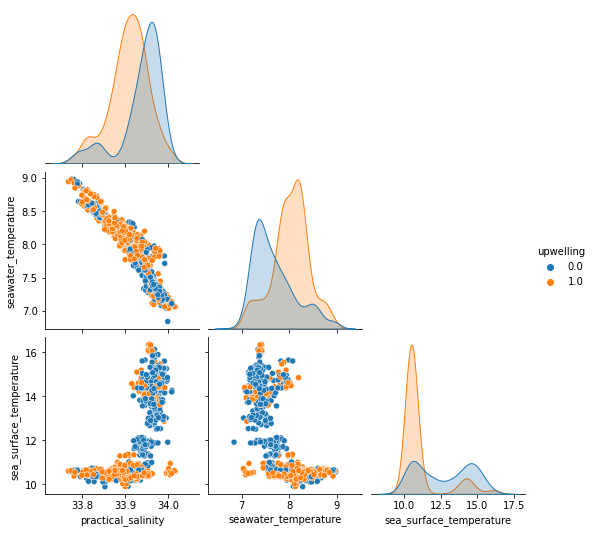

In [60]:
sns.pairplot(misclass_df_dt, corner=True, hue='upwelling');

In [61]:
df_resampled['CUTI'] = df['CUTI']

df['CUTI']

0         1.731
1         1.731
2         1.731
3         1.731
4         1.731
          ...  
329194   -0.194
329195   -0.194
329196   -0.194
329197   -0.194
329198   -0.194
Name: CUTI, Length: 329199, dtype: float64

In [81]:
sns.set_style('whitegrid')

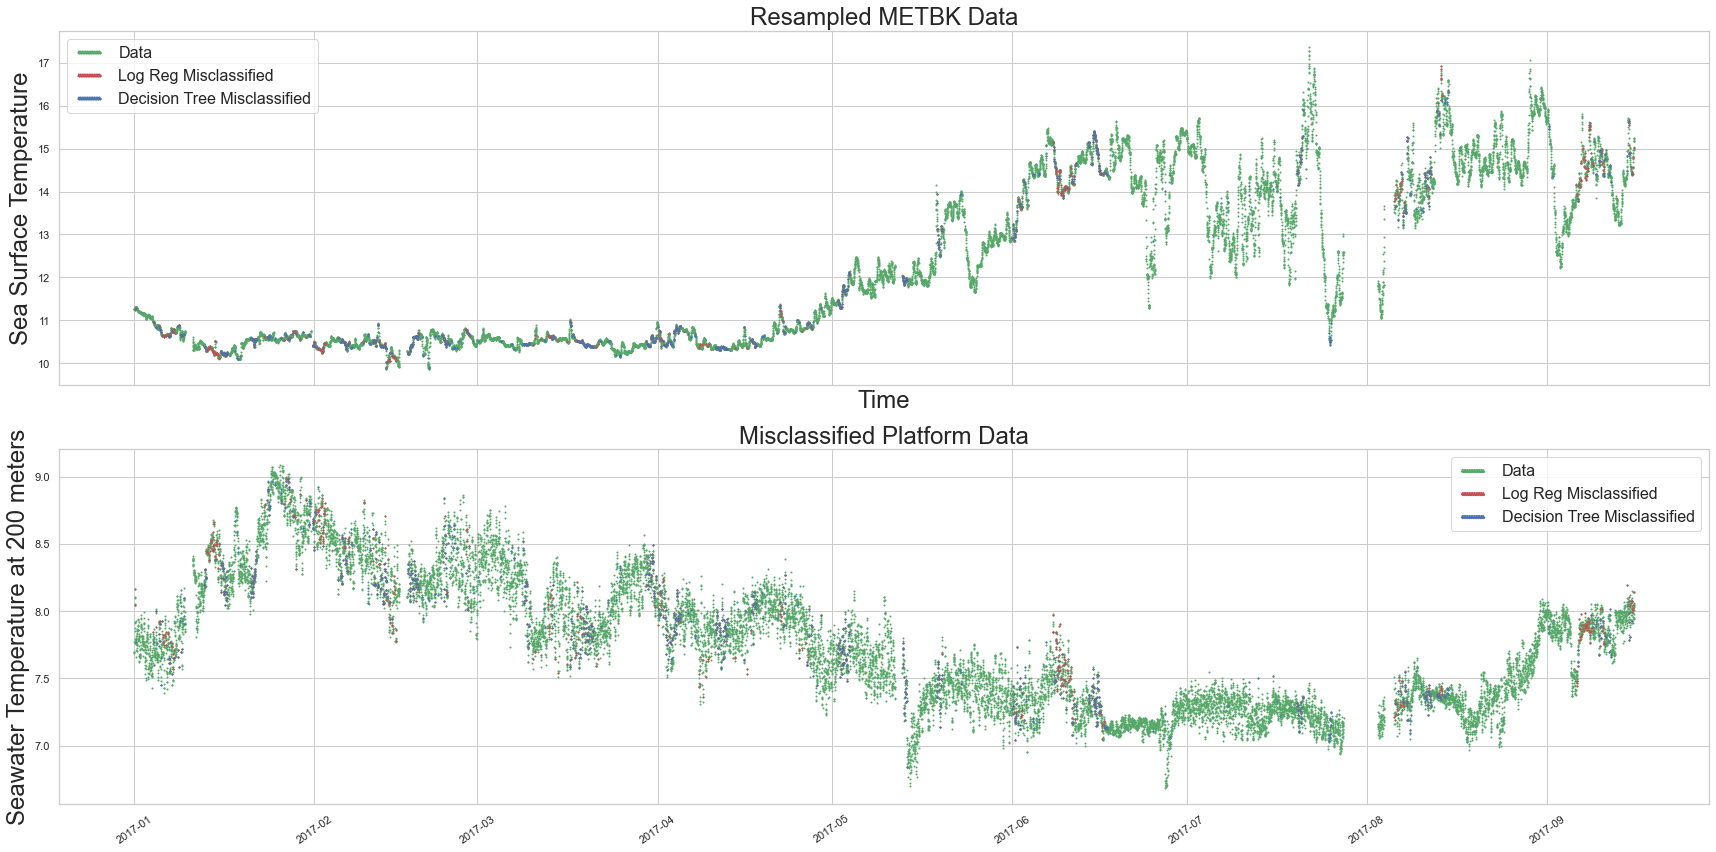

In [82]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df_resampled['time'], y=df_resampled['seawater_temperature'], c='g', s=1, label='Data')
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Misclassified Platform Data', size=24)

ax1.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['seawater_temperature'], c='r', s=1, label='Log Reg Misclassified')
ax1.scatter(x=misclass_df_dt['time'], y=misclass_df_dt['seawater_temperature'], c='b', s=1, label='Decision Tree Misclassified')

ax2.scatter(x=df_resampled['time'], y=df_resampled['sea_surface_temperature'], c='g', s=1, label='Data')
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('Resampled METBK Data', size=24)

ax2.scatter(x=misclass_df_lr['time'], y=misclass_df_lr['sea_surface_temperature'], c='r', s=1, label='Log Reg Misclassified')
ax2.scatter(x=misclass_df_dt['time'], y=misclass_df_dt['sea_surface_temperature'], c='b', s=1, label='Decision Tree Misclassified')

ax2.legend(fontsize=16, scatterpoints=40)
ax1.legend(fontsize=16, scatterpoints=40)
plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('../figures/misclassified_data.png')

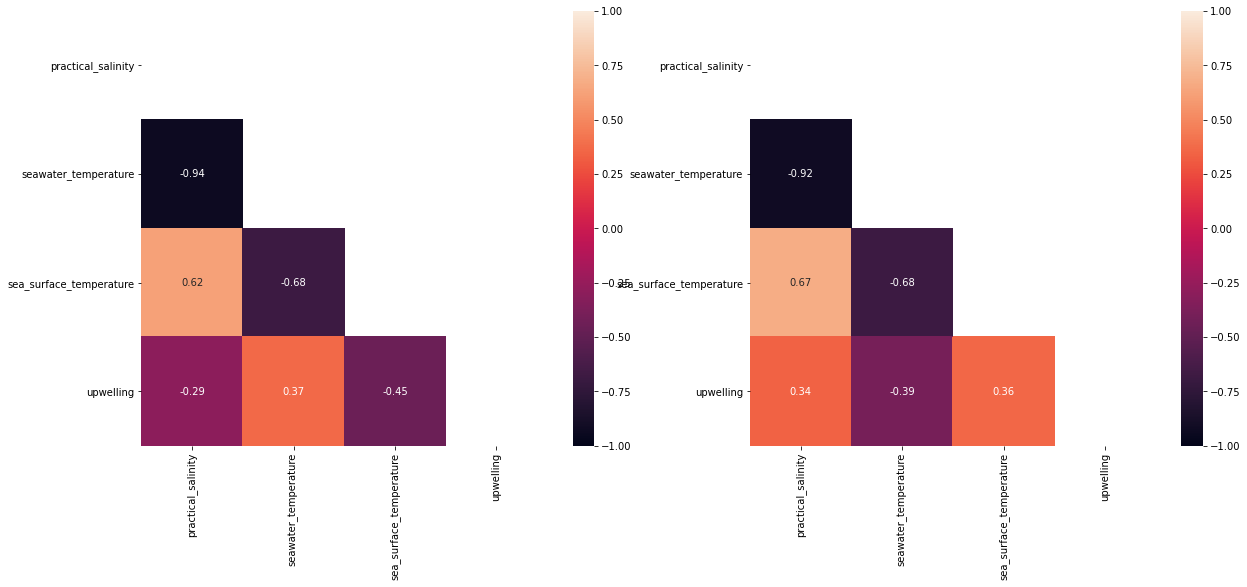

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

corr = misclass_df_dt.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(misclass_df_dt.corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax1)

corr = df_resampled.drop(columns='CUTI').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_resampled.drop(columns='CUTI').corr(), annot=True, vmin=-1, vmax=1, mask=mask, ax=ax2);